In [1]:
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

### Data loading and preprocessing

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomErasing(1, scale=(0.1, 0.25), ratio=(1.2, 3.3)),
    transforms.RandomAffine(0, (1/7, 1/7))
])
train_data = torchvision.datasets.CIFAR10('.', train  = True, transform=transform)
test_data = torchvision.datasets.CIFAR10('.', train  = False, transform=transforms.ToTensor())

In [3]:
size_train_data = train_data.data.shape
size_test_data = test_data.data.shape
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_labels = train_data.classes
num_class = len(class_labels)

assert size_train_data == (50_000, 32, 32, 3), "Incorrect training data size"
assert size_test_data == (10_000, 32, 32, 3), "Incorrect test data size"
assert num_class == 10, "Invalid number of classes"
assert classes == class_labels, "Class mismatch"

print("Size of train data:", size_train_data)
print("\nSize of test data:", size_test_data)
print("\nNumber of classes:", num_class)
print("\nClasses lables:", class_labels)

Size of train data: (50000, 32, 32, 3)

Size of test data: (10000, 32, 32, 3)

Number of classes: 10

Classes lables: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
import random

def show_images(data):
    fig, axs = plt.subplots(2, 8, figsize=(17, 5))

    for ax, img in zip(axs.ravel(), random.choices(data, k=16)):
        ax.imshow(img[0].permute(1, 2, 0))
        ax.set_title(f"{class_labels[img[1]]}")
    plt.tight_layout()

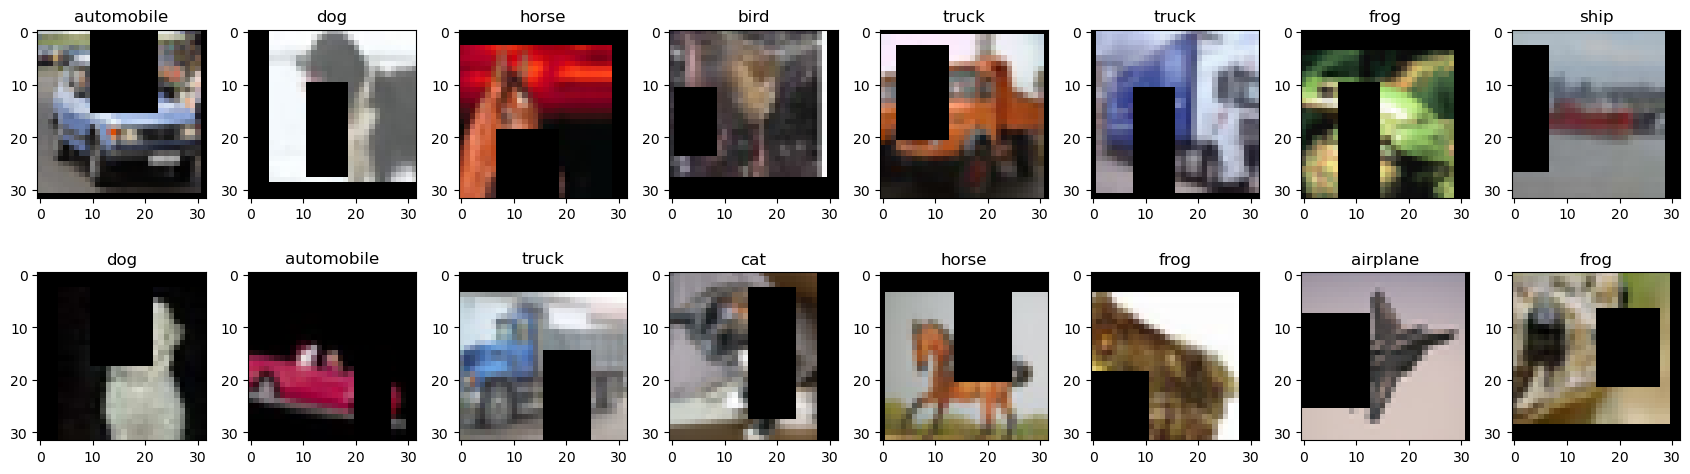

In [5]:
show_images(train_data)

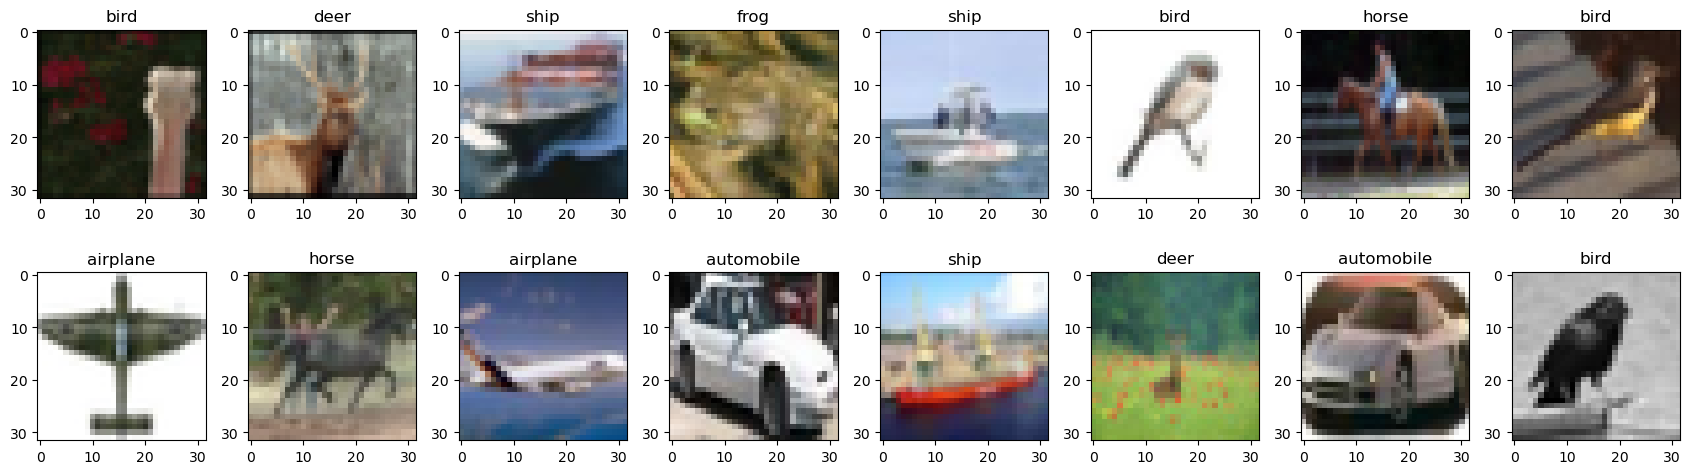

In [6]:
show_images(test_data)

In [7]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### Convolutional Neural Network

In [8]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten()
        )

        self.linear = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        return x

In [9]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

batch_size = 512
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [10]:
model = ConvModel().to(device)

In [11]:
print(model)

ConvModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running


(process:15192): Pango-WARNING **: 09:00:29.500: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


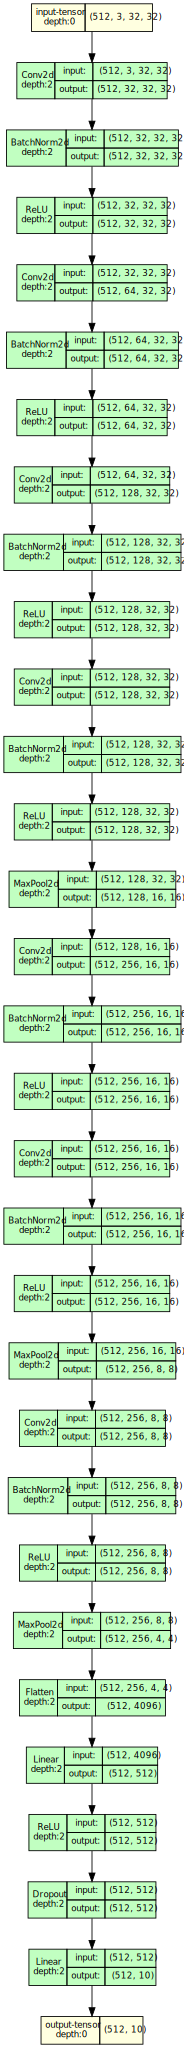

In [12]:
from torchview import draw_graph
model_graph = draw_graph(model, input_size=(batch_size, 3, 32, 32))
model_graph.resize_graph(scale=10.0)
model_graph.visual_graph

### Model training and testing

In [13]:
def fit(model, criterion, optimizer, dataloader):
  total_loss = 0
  total_accuracy = 0

  model.train(True)
  for batch in tqdm(dataloader):
    optimizer.zero_grad()
    x, y = batch[0], batch[1]
    pred = model(x.to(device))
    loss = criterion(pred, y.to(device))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_accuracy += np.mean(y.numpy() ==  pred.cpu().max(1)[1].data.numpy())

  return total_loss/len(dataloader), total_accuracy/len(dataloader)

In [14]:
def eval(model, criterion, dataloader):
  total_loss = 0
  total_accuracy = 0

  model.eval()
  with torch.no_grad():
      for batch in tqdm(dataloader):
        x, y = batch[0], batch[1]
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))
        total_loss += loss.item()
        total_accuracy += np.mean(y.numpy() ==  pred.cpu().max(1)[1].data.numpy())

  return total_loss/len(dataloader), total_accuracy/len(dataloader)

In [15]:
learning_rate = 1e-3
epochs = 120

cross_ent_loss = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

loss_history_train = []
loss_history_test = []
acc_history_train = []
acc_history_test = []
total_time = 0

In [16]:
print('Information about the parameters of the learning algorithm:\n')
print('Batch size =', batch_size)
print('\nNumber of epochs =', epochs)
print('\nCriterion:', cross_ent_loss.__name__)
print('\nLearning rate =', learning_rate)
print('\nOptimizer:', optimizer)

Information about the parameters of the learning algorithm:

Batch size = 512

Number of epochs = 120

Criterion: cross_entropy

Learning rate = 0.001

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [17]:
import time

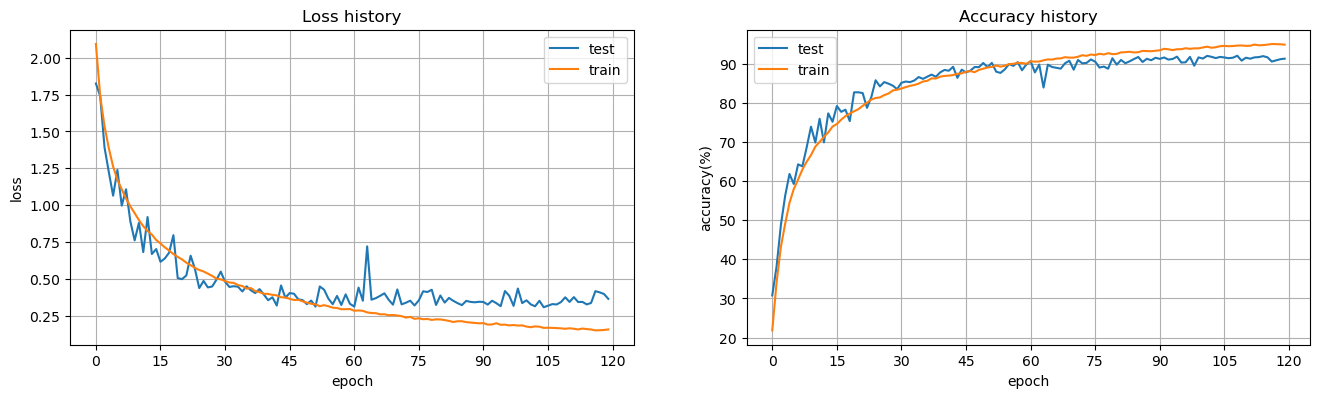

Time spent per training epoch: 45.2 seconds
Training loss: 0.1564
Training accuracy: 94.83%
----------------------------------------

Final test loss: 0.3641

Final test accuracy: 91.25%

Training time: 90.99 mins


In [18]:
for epoch in range(epochs):

  start_time = time.time()
  train_loss, train_acc = fit(model, cross_ent_loss, optimizer, train_dataloader)
  end_time = time.time()
  train_acc = round(train_acc * 100, 2)

  test_loss, test_acc = eval(model, cross_ent_loss, test_dataloader)
  test_acc = round(test_acc * 100, 2)

  loss_history_train.append(train_loss)
  loss_history_test.append(test_loss)
  acc_history_train.append(train_acc)
  acc_history_test.append(test_acc)

  clear_output(True)
  plt.figure(figsize=(16, 9))
  plt.subplot(2, 2, 1)
  plt.title("Loss history")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), loss_history_test, label = "test")
  plt.plot(list(range(epoch+1)), loss_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid()

  plt.subplot(2, 2, 2)
  plt.title("Accuracy history")
  plt.ylabel("accuracy(%)")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), acc_history_test, label = "test")
  plt.plot(list(range(epoch+1)), acc_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid()
  plt.show()

  time_epoch = round((end_time - start_time), 1)
  total_time += time_epoch
  print(f"Time spent per training epoch: {time_epoch} seconds")
  print(f"Training loss:", round(train_loss, 4))
  print(f"Training accuracy: {train_acc}%")


print("-"*40)
print("\nFinal test loss:", round(loss_history_test[-1], 4))
print(f"\nFinal test accuracy: {acc_history_test[-1]}%")
print(f"\nTraining time: {round(total_time/60, 2)} mins")

### Visualization

In [19]:
batch = next(iter(test_dataloader))
datas = batch[0][32:48]
lables = batch[1][32:48]

In [20]:
pred = model(datas.to(device)).cpu().max(1)[1]
pred, lables

(tensor([4, 5, 9, 2, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9]),
 tensor([4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9]))

In [21]:
def show_images_model(data, pred, lables):
    fig, axs = plt.subplots(2, 8, figsize=(16, 5))

    for i, (ax, img) in enumerate(zip(axs.ravel(), data)):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(f"t: {class_labels[lables[i]]}, p: {class_labels[pred[i]]}")
        ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
    plt.tight_layout()

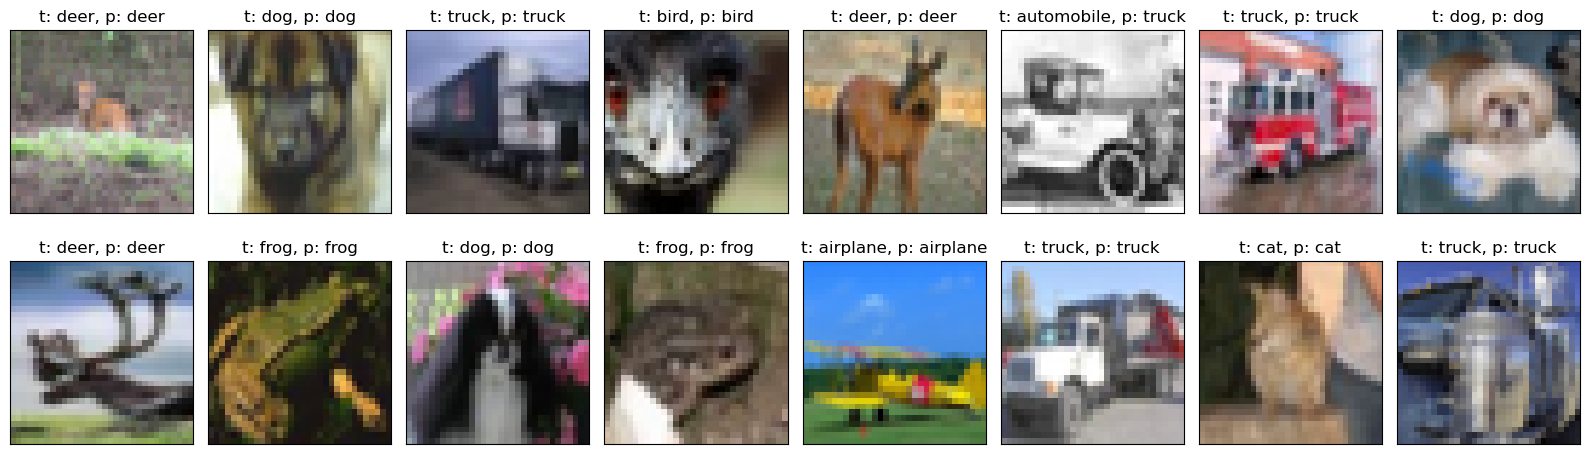

In [22]:
show_images_model(datas, pred, lables)

### Сonclusions

1. Solved the problem of image classification on the сifar-10 dataset
2. To increase the representativeness of the data, preliminary processing of the training data was carried out: the images were randomly rotated horizontally, a random rectangular area in the image was cut out, the images were randomly shifted horizontally and vertically
3. When a model is trained on more diverse data, it generalizes better to new data that it has not seen before. This allows her to better cope with unknown situations in the real world and improves her performance
4. Convolutional neural network architecture built
5. Training options: batch size = 512, number of epochs = 120, criterion: cross entropy, learning rate = 1e-3, optimizer: Adam
6. Model quality on test data: accuracy = 91%